In [1]:
import numpy as np
import pandas as pd
import vectorbtpro as vbt

In [2]:
## Load m1 data
m1_data = vbt.HDFData.fetch('../data/GU_OHLCV_3Y.h5')
m1_data.wrapper.index #pandas doaesn't recognise the frequency because of missing timestamps

DatetimeIndex(['2019-08-27 00:00:00+00:00', '2019-08-27 00:01:00+00:00',
               '2019-08-27 00:02:00+00:00', '2019-08-27 00:03:00+00:00',
               '2019-08-27 00:04:00+00:00', '2019-08-27 00:05:00+00:00',
               '2019-08-27 00:06:00+00:00', '2019-08-27 00:07:00+00:00',
               '2019-08-27 00:08:00+00:00', '2019-08-27 00:09:00+00:00',
               ...
               '2022-08-26 16:50:00+00:00', '2022-08-26 16:51:00+00:00',
               '2022-08-26 16:52:00+00:00', '2022-08-26 16:53:00+00:00',
               '2022-08-26 16:54:00+00:00', '2022-08-26 16:55:00+00:00',
               '2022-08-26 16:56:00+00:00', '2022-08-26 16:57:00+00:00',
               '2022-08-26 16:58:00+00:00', '2022-08-26 16:59:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=1122468, freq=None)

In [3]:
m5_data  = m1_data.resample('5T')   # Convert 1 Minute to 5 Minute
m15_data = m1_data.resample('15T')  # Convert 1 Minute to 15 Minute
m30_data = m1_data.resample('30T')  # Convert 1 Minute to 30 Minute
h1_data = m1_data.resample("1h")    # Convert 1 Minute to 1 hour
h4_data = m1_data.resample("4h")    # Convert 1 Minute to 4 hour
d1_data = m1_data.resample("1d")    # Convert 1 Minute to daily

In [4]:
# Obtain all the closing  prices using the .get() method
m5_close = m5_data.get()['Close']
m15_close = m15_data.get()['Close']

##m30 data
m30_open  = m30_data.get()['Open']
m30_close = m30_data.get()['Close']
m30_high  = m30_data.get()['High']
m30_low   = m30_data.get()['Low']

## h1 data
h1_open  = h1_data.get()['Open']
h1_close = h1_data.get()['Close']
h1_high  = h1_data.get()['High']
h1_low   = h1_data.get()['Low']

## h4 data
h4_open  = h4_data.get()['Open']
h4_close = h4_data.get()['Close']
h4_high  = h4_data.get()['High']
h4_low   = h4_data.get()['Low']

## 1D data
d1_open  = d1_data.get()['Open']
d1_close = d1_data.get()['Close']
d1_high  = d1_data.get()['High']
d1_low   = d1_data.get()['Low']

### Creating the Indicators for multi-timeframes

**Note** : The method of indicator creation shown below using `talib('IndicatorName').run` with `broadcast_kwargs` argument automatically does the [`ffill()` operation](https://github.com/polakowo/vectorbt.pro/blob/df5370824c9368406c0a06ddd0befeb56727e4c4/vectorbtpro/indicators/factory.py#L2868)

In [5]:
rsi_period = 21

## Method 2 - Alternate fancier method of constructing indicator data for MTF data
rsi = vbt.talib("RSI", timeperiod = rsi_period).run(m5_close, skipna=True,
                                                   timeframe=['5T','15T' ,'30T','1h','4h'],#,'1d'],
                                                   broadcast_kwargs=dict(wrapper_kwargs=dict(freq="5T"))).real
                                                   

bbands_price = vbt.talib("BBANDS").run(m5_close, skipna=True, 
                                        timeframe=['5T','15T' ,'30T','1h','4h'],#,'1d'], 
                                        broadcast_kwargs=dict(wrapper_kwargs=dict(freq="5T")))


bbands_rsi = vbt.talib("BBANDS").run(rsi['5T'], skipna=True, 
                                    timeframe=['5T','15T' ,'30T','1h','4h'],#,'1d'], 
                                    broadcast_kwargs=dict(wrapper_kwargs=dict(freq="5T")))

### Resample and creating a multi-time frame dataframe

Upsampling higher timeframe (`low frequency`) data to lower timeframe (`high frequency`) data

In [6]:
def create_resamplers(result_dict_keys_list : list, source_indices : list,  source_frequencies :list, target_index : pd.Series, target_freq : str):
    """
    Creates a dictionary of vbtpro resampler objects.

    Parameters
    ==========
    result_dict_keys_list : list, list of strings, which are keys of the output dictionary
    source_indices        : list, list of pd.time series objects of the higher timeframes
    source_frequencies    : list, list of strings, which are short form representation of the time series order. Eg:["1D", "4h"]
    target_index          : pd.Series, target time series for the resampler objects
    target_freq           : str, target time frequency for the resampler objects
                            use the 1st frequency in source_frequencies list

    Returns
    ===========
    
    resamplers_dict       : dict, vbt pro resampler objects
    
    """
    
    
    resamplers = []
    for si, sf in zip(source_indices, source_frequencies):
        resamplers.append(vbt.Resampler(source_index = si,  target_index = target_index,  source_freq=sf, target_freq=target_freq))
    return dict(zip(result_dict_keys_list, resamplers))

In [7]:
## Create Resampler Objects for upsampling
src_indices = [m15_close.index, m30_close.index, h1_close.index, h4_close.index ] # , d1_close.index
src_frequencies = ["15T", "30T", "1h", "4h"] #, "1D"
resampler_dict_keys = ["m15_m5", "m30_m5", "h1_m5", "h4_m5"] #, "d1_m5"

list_resamplers = create_resamplers(resampler_dict_keys, src_indices, src_frequencies, m5_close.index, "5T")
# list_resamplers = create_resamplers(resampler_dict_keys, src_indices, src_frequencies, m15_close.index, "15T")
list_resamplers

{'m15_m5': <vectorbtpro.base.resampling.base.Resampler at 0x291133820>,
 'm30_m5': <vectorbtpro.base.resampling.base.Resampler at 0x291132a70>,
 'h1_m5': <vectorbtpro.base.resampling.base.Resampler at 0x291132f50>,
 'h4_m5': <vectorbtpro.base.resampling.base.Resampler at 0x291133970>}

In [8]:
## Initialize  dictionary

data = {"m5_close" : m5_close.ffill(), "m5_rsi" : rsi['5T'], 
        "m5_bband_price_upper" : bbands_price['5T'].upperband,  "m5_bband_price_middle" : bbands_price['5T'].middleband,  "m5_bband_price_lower" : bbands_price['5T'].lowerband,
        "m5_bband_rsi_upper" : bbands_rsi['5T'].upperband,  "m5_bband_rsi_middle" : bbands_rsi['5T'].middleband, "m5_bband_rsi_lower" : bbands_rsi['5T'].lowerband 
        }

In [9]:
## Use along with method 1
series_to_resample = [
    # [m5_close],
    [m15_close],
    [m30_close],
    [h1_open, h1_high, h1_low, h1_close],
    [h4_open, h4_high, h4_low, h4_close],
    # [d1_close]
    ]


data_keys = [
    # ["m5_close"],
    ["m15_close"], 
    ["m30_close"],
    ["h1_open", "h1_high", "h1_low" ,"h1_close"], 
    ["h4_open", "h4_high", "h4_low" ,"h4_close"],
    # ["d1_close"]
         ]

In [10]:
## Just resample OHLC prices (upsampling) of higher timeframes to 5min frequency

for lst_series, lst_keys, resampler in zip(series_to_resample, data_keys, resampler_dict_keys):
    for key, time_series in zip(lst_keys, lst_series):
        if key.lower().endswith('open'):
            print('Resampling',key,'differently using vbt.resample_opening')
            resampled_time_series = time_series.vbt.resample_opening(list_resamplers[resampler])
        else:
            resampled_time_series = time_series.vbt.resample_closing(list_resamplers[resampler])
        data[key] = resampled_time_series.ffill()

Resampling h1_open differently using vbt.resample_opening
Resampling h4_open differently using vbt.resample_opening


In [11]:
## Assign key, value pairs for method 2 of Automated One-liner MTF indicator creation method
col_values = [
    [rsi['15T'], bbands_price['15T'].upperband, bbands_price['15T'].middleband, bbands_price['15T'].lowerband, bbands_rsi['15T'].upperband, bbands_rsi['15T'].middleband, bbands_rsi['15T'].lowerband],
    [rsi['30T'], bbands_price['30T'].upperband, bbands_price['30T'].middleband, bbands_price['30T'].lowerband, bbands_rsi['30T'].upperband, bbands_rsi['30T'].middleband, bbands_rsi['30T'].lowerband],
    [rsi['1h'], bbands_price['1h'].upperband, bbands_price['1h'].middleband, bbands_price['1h'].lowerband, bbands_rsi['1h'].upperband, bbands_rsi['1h'].middleband, bbands_rsi['1h'].lowerband],
    [rsi['4h'], bbands_price['4h'].upperband, bbands_price['4h'].middleband, bbands_price['4h'].lowerband, bbands_rsi['4h'].upperband, bbands_rsi['4h'].middleband, bbands_rsi['4h'].lowerband],
    # [rsi['1d'], bbands_price['1d'].upperband, bbands_price['1d'].middleband, bbands_price['1d'].lowerband, bbands_rsi['1d'].upperband, bbands_rsi['1d'].middleband, bbands_rsi['1d'].lowerband]
    ]


col_keys = [
    ["m15_rsi", "m15_bband_price_upper",  "m15_bband_price_middle", "m15_bband_price_lower",  "m15_bband_rsi_upper",  "m15_bband_rsi_middle", "m15_bband_rsi_lower"], 
    ["m30_rsi", "m30_bband_price_upper",  "m30_bband_price_middle", "m30_bband_price_lower",  "m30_bband_rsi_upper",  "m30_bband_rsi_middle", "m30_bband_rsi_lower"],
    ["h1_rsi", "h1_bband_price_upper",  "h1_bband_price_middle",  "h1_bband_price_lower",  "h1_bband_rsi_upper",  "h1_bband_rsi_middle", "h1_bband_rsi_lower" ],
    ["h4_rsi", "h4_bband_price_upper",  "h4_bband_price_middle",  "h4_bband_price_lower",  "h4_bband_rsi_upper",  "h4_bband_rsi_middle", "h4_bband_rsi_lower" ],
    # ["d1_rsi", "d1_bband_price_upper",  "d1_bband_price_middle",  "d1_bband_price_lower",  "d1_bband_rsi_upper",  "d1_bband_rsi_middle", "d1_bband_rsi_lower" ]
         ]

In [12]:
## Assign key, value pairs for method 2 of Automated One-liner MTF indicator creation method
for lst_series, lst_keys in zip(col_values, col_keys):
    for key, time_series in zip(lst_keys, lst_series):
        data[key] = time_series

Constructing DataFrame of Multi-Time Frame Data

In [13]:
cols_order = ['m5_close','m5_rsi','m5_bband_price_upper','m5_bband_price_middle','m5_bband_price_lower','m5_bband_rsi_upper','m5_bband_rsi_middle','m5_bband_rsi_lower',
'm15_close','m15_rsi','m15_bband_price_upper','m15_bband_price_middle', 'm15_bband_price_lower','m15_bband_rsi_upper','m15_bband_rsi_middle', 'm15_bband_rsi_lower',
'm30_close','m30_rsi', 'm30_bband_price_upper', 'm30_bband_price_middle', 'm30_bband_price_lower', 'm30_bband_rsi_upper', 'm30_bband_rsi_middle', 'm30_bband_rsi_lower',
 'h1_open', 'h1_high', 'h1_low', 'h1_close', 'h1_rsi', 'h1_bband_price_upper', 'h1_bband_price_middle', 'h1_bband_price_lower', 'h1_bband_rsi_upper', 'h1_bband_rsi_middle','h1_bband_rsi_lower',
 'h4_open', 'h4_high', 'h4_low', 'h4_close', 'h4_rsi', 'h4_bband_price_upper', 'h4_bband_price_middle', 'h4_bband_price_lower', 'h4_bband_rsi_upper', 'h4_bband_rsi_middle', 'h4_bband_rsi_lower']

In [14]:
## construct a multi-timeframe dataframe
mtf_df = pd.DataFrame(data)[cols_order]
print("Length of mtf_df:",len(mtf_df), f'on {mtf_df.index.freq} frequency')

Length of mtf_df: 315564 on <5 * Minutes> frequency


In [15]:
for col in mtf_df.columns:
    time_series = mtf_df[col]
    print(col,time_series.index.freq, 'length:' ,len(time_series), 'NULL Count:',time_series.isna().sum())

m5_close <5 * Minutes> length: 315564 NULL Count: 0
m5_rsi <5 * Minutes> length: 315564 NULL Count: 21
m5_bband_price_upper <5 * Minutes> length: 315564 NULL Count: 4
m5_bband_price_middle <5 * Minutes> length: 315564 NULL Count: 4
m5_bband_price_lower <5 * Minutes> length: 315564 NULL Count: 4
m5_bband_rsi_upper <5 * Minutes> length: 315564 NULL Count: 25
m5_bband_rsi_middle <5 * Minutes> length: 315564 NULL Count: 25
m5_bband_rsi_lower <5 * Minutes> length: 315564 NULL Count: 25
m15_close <5 * Minutes> length: 315564 NULL Count: 2
m15_rsi <5 * Minutes> length: 315564 NULL Count: 65
m15_bband_price_upper <5 * Minutes> length: 315564 NULL Count: 14
m15_bband_price_middle <5 * Minutes> length: 315564 NULL Count: 14
m15_bband_price_lower <5 * Minutes> length: 315564 NULL Count: 14
m15_bband_rsi_upper <5 * Minutes> length: 315564 NULL Count: 35
m15_bband_rsi_middle <5 * Minutes> length: 315564 NULL Count: 35
m15_bband_rsi_lower <5 * Minutes> length: 315564 NULL Count: 35
m30_close <5 * Mi

In [16]:
display(mtf_df)

,m5_close,m5_rsi,m5_bband_price_upper,m5_bband_price_middle,m5_bband_price_lower,m5_bband_rsi_upper,m5_bband_rsi_middle,m5_bband_rsi_lower,m15_close,m15_rsi,...,h4_high,h4_low,h4_close,h4_rsi,h4_bband_price_upper,h4_bband_price_middle,h4_bband_price_lower,h4_bband_rsi_upper,h4_bband_rsi_middle,h4_bband_rsi_lower
time,,,,,,,,,,,,,,,,,,,,,
2019-08-27 00:00:00+00:00,1.221300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-27 00:05:00+00:00,1.221280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-27 00:10:00+00:00,1.221165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.221165,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-27 00:15:00+00:00,1.221145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.221165,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-27 00:20:00+00:00,1.221595,NaN,1.221619,1.221297,1.220975,NaN,NaN,NaN,1.221165,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-26 16:35:00+00:00,1.173785,40.177989,1.174308,1.173867,1.173426,45.681371,40.345471,35.009572,1.174110,35.365534,...,1.17836,1.17354,1.173765,38.014083,1.185437,1.17896,1.172483,56.090301,42.797867,29.505433
2022-08-26 16:40:00+00:00,1.173915,41.774054,1.174169,1.173954,1.173739,43.384374,41.640093,39.895813,1.173915,34.806861,...,1.17836,1.17354,1.173765,38.014083,1.185437,1.17896,1.172483,56.090301,42.797867,29.505433
2022-08-26 16:45:00+00:00,1.173885,41.505727,1.174141,1.173929,1.173717,43.325590,41.585151,39.844713,1.173915,34.806861,...,1.17836,1.17354,1.173765,38.014083,1.185437,1.17896,1.172483,56.090301,42.797867,29.505433


In [17]:
# print(mtf_df.columns.to_list())

In [18]:
mtf_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315564 entries, 2019-08-27 00:00:00+00:00 to 2022-08-26 16:55:00+00:00
Freq: 5T
Data columns (total 46 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   m5_close                315564 non-null  float64
 1   m5_rsi                  315543 non-null  float64
 2   m5_bband_price_upper    315560 non-null  float64
 3   m5_bband_price_middle   315560 non-null  float64
 4   m5_bband_price_lower    315560 non-null  float64
 5   m5_bband_rsi_upper      315539 non-null  float64
 6   m5_bband_rsi_middle     315539 non-null  float64
 7   m5_bband_rsi_lower      315539 non-null  float64
 8   m15_close               315562 non-null  float64
 9   m15_rsi                 315499 non-null  float64
 10  m15_bband_price_upper   315550 non-null  float64
 11  m15_bband_price_middle  315550 non-null  float64
 12  m15_bband_price_lower   315550 non-null  float64
 13  m15_bband_rsi_upper

In [19]:
mtf_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315564 entries, 2019-08-27 00:00:00+00:00 to 2022-08-26 16:55:00+00:00
Freq: 5T
Data columns (total 46 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   m5_close                315564 non-null  float64
 1   m5_rsi                  315543 non-null  float64
 2   m5_bband_price_upper    315560 non-null  float64
 3   m5_bband_price_middle   315560 non-null  float64
 4   m5_bband_price_lower    315560 non-null  float64
 5   m5_bband_rsi_upper      315539 non-null  float64
 6   m5_bband_rsi_middle     315539 non-null  float64
 7   m5_bband_rsi_lower      315539 non-null  float64
 8   m15_close               315562 non-null  float64
 9   m15_rsi                 315499 non-null  float64
 10  m15_bband_price_upper   315550 non-null  float64
 11  m15_bband_price_middle  315550 non-null  float64
 12  m15_bband_price_lower   315550 non-null  float64
 13  m15_bband_rsi_upper

### Double Bollinger Band - Strategy Conditions
The trading conditions (rules) of the strategy are as follows:

1. A long (buy) signal is generated whenever the H4 market (Low) price surpasses its lower Bollinger band after having been below it while simultaneously, the 5m RSI surpasses its lower Bollinger band after having been below it.

2. A short (sell) signal is generated whenever the H4 market (High) price breaks its upper Bollinger band after having been above it while simultaneously, the 5m RSI breaks below its upper Bollinger band after having been above it.

In [20]:
required_cols = ['m5_close', "m5_rsi" , "m5_bband_rsi_lower", "m5_bband_rsi_upper" ,
                #  "h1_low", "h1_rsi" , "h1_bband_price_lower" ,
                 'h4_low', "h4_rsi", "h4_bband_price_lower"]

In [21]:
mtf_df[required_cols][(mtf_df['h4_low'] < mtf_df['h4_bband_price_lower'])]

,m5_close,m5_rsi,m5_bband_rsi_lower,m5_bband_rsi_upper,h4_low,h4_rsi,h4_bband_price_lower
time,,,,,,,
2019-08-28 07:55:00+00:00,1.221015,46.965201,46.747665,54.316741,1.21560,NaN,1.220568
2019-08-28 08:00:00+00:00,1.221250,48.294728,45.907702,53.849016,1.21560,NaN,1.220568
2019-08-28 08:05:00+00:00,1.220470,44.414337,43.341328,53.224800,1.21560,NaN,1.220568
2019-08-28 08:10:00+00:00,1.220345,43.821860,41.895978,51.664768,1.21560,NaN,1.220568
2019-08-28 08:15:00+00:00,1.219830,41.430970,40.153428,49.817410,1.21560,NaN,1.220568
...,...,...,...,...,...,...,...
2022-08-26 15:30:00+00:00,1.173955,37.202000,36.741689,39.972650,1.17539,41.062856,1.176465
2022-08-26 15:35:00+00:00,1.174020,37.862219,37.083730,38.895128,1.17539,41.062856,1.176465
2022-08-26 15:40:00+00:00,1.173700,35.910620,35.679428,39.450954,1.17539,41.062856,1.176465


In [22]:
## Higher values greater than 1.0 are like moving up the lower RSI b-band, signifying if the lowerband rsi is anywhere around 1% of the lower b-band validate that case as True
# bb_upper_fract = 0.99
# bb_lower_fract = 1.01

bb_upper_fract = 1.0
bb_lower_fract = 1.0

In [23]:
mtf_df[required_cols][(mtf_df['m5_rsi'] < (bb_lower_fract * mtf_df['m5_bband_rsi_lower']) )]

,m5_close,m5_rsi,m5_bband_rsi_lower,m5_bband_rsi_upper,h4_low,h4_rsi,h4_bband_price_lower
time,,,,,,,
2019-08-30 17:15:00+00:00,1.216260,51.680623,51.680623,51.680623,1.213945,37.738420,1.216065
2019-08-30 17:20:00+00:00,1.216260,51.680623,51.680623,51.680623,1.213945,37.738420,1.216065
2019-08-30 17:25:00+00:00,1.216260,51.680623,51.680623,51.680623,1.213945,37.738420,1.216065
2019-08-30 17:30:00+00:00,1.216260,51.680623,51.680623,51.680623,1.213945,37.738420,1.216065
2019-08-30 17:35:00+00:00,1.216260,51.680623,51.680623,51.680623,1.213945,37.738420,1.216065
...,...,...,...,...,...,...,...
2022-08-21 16:35:00+00:00,1.182665,53.375495,53.375495,53.375495,1.182465,28.142368,1.177334
2022-08-21 16:40:00+00:00,1.182665,53.375495,53.375495,53.375495,1.182465,28.142368,1.177334
2022-08-21 16:45:00+00:00,1.182665,53.375495,53.375495,53.375495,1.182465,28.142368,1.177334


In [24]:
## When additional checking if RSI goes below 30 it Yields less results
mtf_df[required_cols][(mtf_df['m5_rsi'] < (bb_lower_fract * mtf_df['m5_bband_rsi_lower']) ) & (mtf_df['m5_rsi'] <= 30)]

,m5_close,m5_rsi,m5_bband_rsi_lower,m5_bband_rsi_upper,h4_low,h4_rsi,h4_bband_price_lower
time,,,,,,,
2019-09-08 17:00:00+00:00,1.227225,28.384857,28.384857,46.287159,1.228555,58.262666,1.228130
2020-01-19 17:00:00+00:00,1.300040,24.218430,24.218430,41.800484,1.300625,42.903188,1.297874
2020-04-10 17:15:00+00:00,1.245250,25.333547,25.333547,25.333547,1.246715,61.652927,1.246139
2020-04-10 17:20:00+00:00,1.245250,25.333547,25.333547,25.333547,1.246715,61.652927,1.246139
2020-04-10 17:25:00+00:00,1.245250,25.333547,25.333547,25.333547,1.246715,61.652927,1.246139
...,...,...,...,...,...,...,...
2020-04-12 16:50:00+00:00,1.245250,25.333547,25.333547,25.333547,1.244950,58.881506,1.245093
2020-04-12 16:55:00+00:00,1.245250,25.333547,25.333547,25.333547,1.244950,58.881506,1.245093
2020-05-17 17:00:00+00:00,1.208845,28.434858,28.434858,46.294822,1.210170,32.337441,1.206783


In [25]:
## Final conditions - Using m5, m15 and h4 data 
# mtf_df['entry'] = (mtf_df['h4_low'] <= mtf_df['h4_bband_price_lower']) & (mtf_df['m15_rsi'] <= (bb_lower_fract * mtf_df['m15_bband_rsi_lower']) ) & ((mtf_df['m5_rsi'] <= 30))
# mtf_df['exit']  = (mtf_df['h4_high'] >= mtf_df['h4_bband_price_upper']) & (mtf_df['m15_rsi'] >= (bb_upper_fract * mtf_df['m15_bband_rsi_upper'])) & ((mtf_df['m5_rsi'] >= 70))

In [26]:
## Final conditions - Using m5 and h4 data 
mtf_df['entry'] = (mtf_df['h4_low'] < mtf_df['h4_bband_price_lower']) & (mtf_df['m5_rsi'] < (bb_lower_fract * mtf_df['m5_bband_rsi_lower']) ) & ((mtf_df['m5_rsi'] < 30))
mtf_df['exit']  = (mtf_df['h4_high'] > mtf_df['h4_bband_price_upper']) & (mtf_df['m5_rsi'] > (bb_upper_fract * mtf_df['m5_bband_rsi_upper'])) & ((mtf_df['m5_rsi'] > 70))


In [27]:
mtf_df['signal'] = 0   
mtf_df['signal'] = np.where( mtf_df['entry'] ,1, 0)
mtf_df['signal'] = np.where( mtf_df['exit'] ,-1, mtf_df['signal'])

In [28]:
entries = mtf_df.signal == 1.0
exits = mtf_df.signal == -1.0

_Cleaning_ `entries` and `exit` signals by removing redundant signals

In [29]:
print(entries.vbt.signals.total(), exits.vbt.signals.total())
print(len(entries), len(exits))

541 0
315564 315564


In [30]:
## Clean redundant and duplicate signals
clean_entries, clean_exits = entries.vbt.signals.clean(exits)

In [31]:
print(entries.vbt.signals.total(),exits.vbt.signals.total())
print(len(clean_entries), len(clean_exits))

541 0
315564 315564


Resampling `entries` and `exits` from `5m` to `H4` for plotting purpose

In [32]:
%%time
## Faster method
h4_entries = entries.vbt.resample_apply("4h", "any", wrap_kwargs=dict(dtype=bool))
h4_exits = exits.vbt.resample_apply("4h", "any", wrap_kwargs=dict(dtype=bool))

CPU times: user 164 ms, sys: 3.74 ms, total: 168 ms
Wall time: 170 ms


In [33]:
print(len(h4_entries),len(h4_exits))
print(h4_entries.vbt.signals.total(),h4_exits.vbt.signals.total())

6575 6575
13 0


In [34]:
clean_h4_entries, clean_h4_exits = h4_entries.vbt.signals.clean(h4_exits)

In [35]:
print(len(clean_h4_entries),len(clean_h4_exits))
print(clean_h4_entries.vbt.signals.total(),clean_h4_exits.vbt.signals.total())

6575 6575
1 0


### Plotting Indicators

In [36]:
## Global Plot Settings
vbt.settings.set_theme("dark")
vbt.settings['plotting']['layout']['width'] = 1280

In [37]:
## Acquire Data for Indicators Plot
h4_df = h4_data.get()
h4_rsi = vbt.talib("RSI", timeperiod = rsi_period).run(h4_data.get("Close"), skipna=True).real
h4_bbands = vbt.talib("BBANDS").run(h4_data.get("Close"), skipna=True)
h4_bbands_rsi = vbt.talib("BBANDS").run(h4_rsi, skipna=True)
h4_df

,Open,High,Low,Close,Volume
time,,,,,
2019-08-27 00:00:00+00:00,1.221095,1.225280,1.220900,1.225030,3.087917e+10
2019-08-27 04:00:00+00:00,1.225045,1.227655,1.224060,1.226965,4.512783e+10
2019-08-27 08:00:00+00:00,1.226960,1.231000,1.225215,1.228735,6.021476e+10
2019-08-27 12:00:00+00:00,1.228740,1.230380,1.228095,1.228765,2.032644e+10
2019-08-27 16:00:00+00:00,1.228780,1.229225,1.228045,1.228070,7.616710e+09
...,...,...,...,...,...
2022-08-26 00:00:00+00:00,1.182580,1.182615,1.177895,1.178830,1.852738e+10
2022-08-26 04:00:00+00:00,1.178845,1.184380,1.177785,1.182145,2.676285e+10
2022-08-26 08:00:00+00:00,1.182135,1.189770,1.175390,1.177480,7.900152e+10


Create Backtest Simulation for 2BB Strategy using `vbt.Portfolio.from_signals()`

In [38]:
pf_2_bb_custom = vbt.Portfolio.from_signals(
    mtf_df['m5_close'], 
    entries=entries, 
    exits=exits, 
    direction = "both",
    freq=pd.Timedelta(minutes=5), 
    init_cash=100000
)

In [39]:
pf_2_bb_custom.stats()

Start                         2019-08-27 00:00:00+00:00
End                           2022-08-26 16:55:00+00:00
Period                               1095 days 17:00:00
Start Value                                    100000.0
Min Value                                  94121.662317
Max Value                                 114391.086127
End Value                                   94306.76571
Total Return [%]                              -5.693234
Benchmark Return [%]                          -3.843855
Total Time Exposure [%]                       79.207071
Max Gross Exposure [%]                            100.0
Max Drawdown [%]                              17.719408
Max Drawdown Duration                 451 days 19:35:00
Total Orders                                          1
Total Fees Paid                                     0.0
Total Trades                                          1
Win Rate [%]                                        NaN
Best Trade [%]                                  

In [40]:
# pf_2_bb_custom.plot().show() ## This takes too long (30 secs) as it uses 5m timeframe
pf_2_bb_custom.resample("1d").plot().show()

In [41]:
# pf_2_bb_custom.orders.plot(xaxis=dict(rangeslider_visible=True),**kwargs1).show()
kwargs1 = {"title_text" : "Orders - Stats & Plot", "title_font_size" : 18}
pf_2_bb_custom.orders.resample("1d").plot(xaxis=dict(rangeslider_visible=True),**kwargs1).show()

<AxesSubplot: >

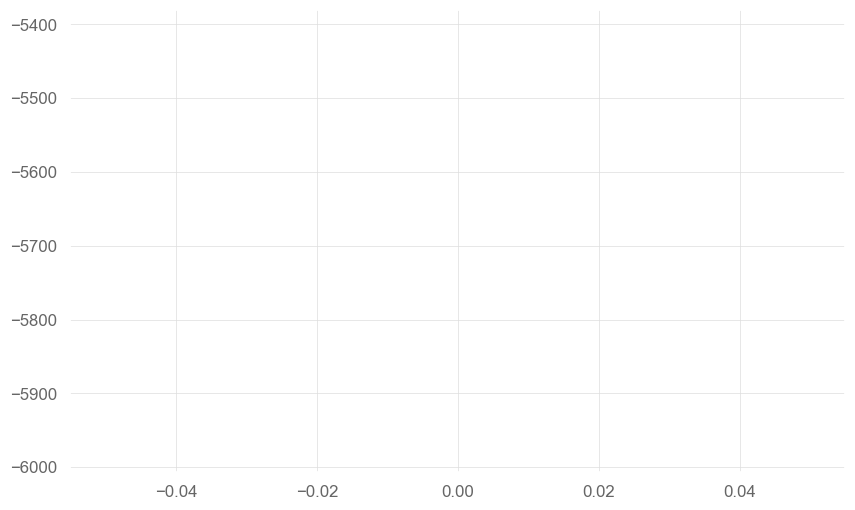

In [42]:
## Simple line plots seem to be using matplotlib
pf_2_bb_custom.trades.records_readable.PnL.cumsum().plot()

In [43]:
pnl_series = pf_2_bb_custom.trades.pnl.to_pd()
pnl_series[pnl_series.notna()]

time
2022-08-26 16:55:00+00:00   -5693.23429
Freq: 5T, dtype: float64

### Creating Stacked SubPlots on Sliced Data

In [44]:
def plot_strategy(slice_lower : str, slice_upper: str, df : pd.DataFrame , rsi : pd.Series,
                         bb_price : vbt.indicators.factory, bb_rsi : vbt.indicators.factory, 
                         entries: pd.Series, exits: pd.Series, 
                         long_trades: pd.DataFrame, short_trades: pd.DataFrame,
                         show_legend : bool = True):
    """Creates a stacked indicator plot for the 2BB strategy.
    Parameters
    ===========
    slice_lower : str, start date of dataframe slice in yyyy.mm.dd format
    slice_upper : str, start date of dataframe slice in yyyy.mm.dd format
    df          : pd.DataFrame, containing the OHLCV data
    rsi         : pd.Series, rsi indicator time series in same freq as df
    bb_price    : vbt.indicators.factory.talib('BBANDS'), computed on df['close'] price
    bb_rsi      : vbt.indicators.factory.talib('BBANDS') computer on RSI
    entries     : pd.Series, time series data of long entries
    exits       : pd.Series, time series data of long exits
    long_trades : pd.DataFrame, long_trades from `pf.trades.records_readable`
    short_trades: pd.DataFrame, short_trades from `pf.trades.records_readable`
    show_legend : bool, switch to show or completely hide the legend box on the plot
    
    Returns
    =======
    fig         : plotly figure object
    """
    kwargs1 = {"title_text" : "H4 OHLCV with BBands on Price and RSI", 
               "title_font_size" : 18,
               "height" : 960,
               "legend" : dict(yanchor="top",y=0.99, xanchor="right",x= 0.1)}
    fig = vbt.make_subplots(rows=2,cols=1, shared_xaxes=True, vertical_spacing=0.1)
    ## Filter Data according to date slice
    df_slice = df[["Open", "High", "Low", "Close"]][slice_lower : slice_upper]
    bb_price = bb_price[slice_lower : slice_upper]
    rsi = rsi[slice_lower : slice_upper]
    bb_rsi = bb_rsi[slice_lower : slice_upper]
    entries = entries[slice_lower : slice_upper]
    exits = exits[slice_lower : slice_upper]
    long_trades = long_trades[slice_lower : slice_upper].reset_index()
    short_trades = short_trades[slice_lower : slice_upper].reset_index()

    ## Retrieve Filled entry and exit prices
    entry_prices = pd.concat([long_trades[['Entry Index', 'Avg Entry Price']], short_trades[['Entry Index', 'Avg Entry Price']]]).sort_values('Entry Index').set_index('Entry Index')
    exit_prices = pd.concat([long_trades[['Exit Index', 'Avg Exit Price']], short_trades[['Exit Index', 'Avg Exit Price']]]).sort_values('Exit Index').set_index('Exit Index')
    entry_prices.index.names = ['time']
    exit_prices.index.names = ['time']
    entry_prices.name = 'Entries'
    exit_prices.name = 'Exits'
    
    ## Retrieve datetime index of rows where price data is NULL
    # retrieve the dates that are in the original datset
    dt_obs = df_slice.index.to_list()
    # Drop rows with missing values
    dt_obs_dropped = df_slice['Close'].dropna().index.to_list()
    # store  dates with missing values
    dt_breaks = [d for d in dt_obs if d not in dt_obs_dropped]

    ## Plot Figures
    df_slice.vbt.ohlcv.plot(add_trace_kwargs=dict(row=1, col=1),  fig=fig, **kwargs1) ## Without Range Slider
    rsi.rename("RSI").vbt.plot(add_trace_kwargs=dict(row=2, col=1), trace_kwargs = dict(connectgaps=True), fig=fig, **kwargs1 ) 

    bb_price.plot(add_trace_kwargs=dict(row=1, col=1),fig=fig, **kwargs1,
                    lowerband_trace_kwargs=dict(fill=None, name = 'BB_Price_Lower', connectgaps=True), 
                    upperband_trace_kwargs=dict(fill=None, name = 'BB_Price_Upper', connectgaps=True),
                    middleband_trace_kwargs=dict(fill=None, name = 'BB_Price_Middle', connectgaps=True) )

    bb_rsi.plot(add_trace_kwargs=dict(row=2, col=1),limits=(25, 75),fig=fig,
                lowerband_trace_kwargs=dict(fill=None, name = 'BB_RSI_Lower', connectgaps=True), 
                upperband_trace_kwargs=dict(fill=None, name = 'BB_RSI_Upper', connectgaps=True),
                middleband_trace_kwargs=dict(fill=None, name = 'BB_RSI_Middle', connectgaps=True))

    ## Add Entries and Long Exits
    entries.vbt.signals.plot_as_entries(df_slice['Close'], fig=fig,
                                        trace_kwargs=dict(marker=dict(color="limegreen", size = 12), 
                                                          name="Entries")
                                            )
    exits.vbt.signals.plot_as_exits(df_slice['Close'], fig = fig,
                                        trace_kwargs=dict(marker=dict(color="red", size = 12), 
                                                        name="Exits") 
                                        )
                                        
    entries.vbt.signals.plot_as_entries(rsi, fig = fig,
                                             add_trace_kwargs=dict(row=2, col=1),
                                             trace_kwargs=dict(marker=dict(color="limegreen"),
                                                               showlegend = False))  

    exits.vbt.signals.plot_as_exits(rsi, fig = fig,showlegend = False,
                                         add_trace_kwargs=dict(row=2, col=1),
                                         trace_kwargs=dict(marker=dict(color="red"),
                                                           showlegend = False))

    ## Dotted Lines for Long Trades
    x_axis_long_entries = long_trades['Entry Index'].map(lambda x : x.replace(microsecond=0))
    y_axis_long_entries = long_trades['Avg Entry Price'].values
    x_axis_long_exits = long_trades['Exit Index'].map(lambda x : x.replace(microsecond=0))
    y_axis_long_exits = long_trades['Avg Exit Price'].values

    for entry_time, entry_price, exit_time, exit_price in zip(x_axis_long_entries, y_axis_long_entries, 
                                                                x_axis_long_exits, y_axis_long_exits):
        fig.add_shape(type="line",x0=entry_time, y0=entry_price, 
                                    x1=exit_time, y1=exit_price,
                                    line=dict(color="aquamarine",width=2,dash="dot"))

    ## Dotted Lines for Short Trades
    x_axis_short_entries = short_trades['Entry Index'].map(lambda x : x.replace(microsecond=0))
    y_axis_short_entries = short_trades['Avg Entry Price'].values
    x_axis_short_exits = short_trades['Exit Index'].map(lambda x : x.replace(microsecond=0))
    y_axis_short_exits = short_trades['Avg Exit Price'].values

    for entry_time, entry_price, exit_time, exit_price in zip(x_axis_short_entries, y_axis_short_entries, 
                                                                x_axis_short_exits, y_axis_short_exits):
        fig.add_shape(type="line",x0=entry_time, y0=entry_price, 
                                    x1=exit_time, y1=exit_price,
                                    line=dict(color="magenta",width=2, dash="dot")) 

    fig.update_xaxes(rangebreaks=[dict(values=dt_breaks)])
    fig.layout.showlegend = show_legend  
    # fig.write_html(f"2BB_Strategy_{slice_lower}_to_{slice_upper}.html")
    
    return fig

In [45]:
df_trades = pf_2_bb_custom.trades.records_readable
df_trades

,Exit Trade Id,Column,Size,Entry Index,Avg Entry Price,Entry Fees,Exit Index,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,0,80305.159607,2020-04-10 19:55:00+00:00,1.24525,0.0,2022-08-26 16:55:00+00:00,1.174355,0.0,-5693.23429,-0.056932,Long,Open,0


In [46]:
long_trades = df_trades[['Entry Index', 'Avg Entry Price', 'Exit Index', 'Avg Exit Price']][df_trades['Direction'] == "Long"].set_index('Entry Index')#.squeeze()
short_trades = df_trades[['Entry Index', 'Avg Entry Price', 'Exit Index', 'Avg Exit Price']][df_trades['Direction'] == "Short"].set_index('Entry Index')#.squeeze()

In [47]:
len(long_trades), len(short_trades)

(1, 0)

In [48]:
slice_lower = '2019.10.01'
slice_higher = '2019.12.30'
fig = plot_strategy(slice_lower, slice_higher, h4_df, h4_rsi, 
                           h4_bbands, h4_bbands_rsi, 
                           clean_h4_entries, clean_h4_exits, 
                           long_trades, short_trades,
                           show_legend = True)

fig.show()

### Save final dataframe with consolidated signals and `P&L`

In [49]:
## Map Signals column into relavant integers to represent long and short entry/exit signals
mtf_df["pnl"] = pnl_series
mtf_df

,m5_close,m5_rsi,m5_bband_price_upper,m5_bband_price_middle,m5_bband_price_lower,m5_bband_rsi_upper,m5_bband_rsi_middle,m5_bband_rsi_lower,m15_close,m15_rsi,...,h4_bband_price_upper,h4_bband_price_middle,h4_bband_price_lower,h4_bband_rsi_upper,h4_bband_rsi_middle,h4_bband_rsi_lower,entry,exit,signal,pnl
time,,,,,,,,,,,,,,,,,,,,,
2019-08-27 00:00:00+00:00,1.221300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,NaN
2019-08-27 00:05:00+00:00,1.221280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,NaN
2019-08-27 00:10:00+00:00,1.221165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.221165,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,NaN
2019-08-27 00:15:00+00:00,1.221145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.221165,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,NaN
2019-08-27 00:20:00+00:00,1.221595,NaN,1.221619,1.221297,1.220975,NaN,NaN,NaN,1.221165,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-26 16:35:00+00:00,1.173785,40.177989,1.174308,1.173867,1.173426,45.681371,40.345471,35.009572,1.174110,35.365534,...,1.185437,1.17896,1.172483,56.090301,42.797867,29.505433,False,False,0,NaN
2022-08-26 16:40:00+00:00,1.173915,41.774054,1.174169,1.173954,1.173739,43.384374,41.640093,39.895813,1.173915,34.806861,...,1.185437,1.17896,1.172483,56.090301,42.797867,29.505433,False,False,0,NaN
2022-08-26 16:45:00+00:00,1.173885,41.505727,1.174141,1.173929,1.173717,43.325590,41.585151,39.844713,1.173915,34.806861,...,1.185437,1.17896,1.172483,56.090301,42.797867,29.505433,False,False,0,NaN


In [50]:
# mtf_df.to_csv("2BB_Final_Simulation.csv", index = False)

In [51]:
mtf_df.columns

Index(['m5_close', 'm5_rsi', 'm5_bband_price_upper', 'm5_bband_price_middle',
       'm5_bband_price_lower', 'm5_bband_rsi_upper', 'm5_bband_rsi_middle',
       'm5_bband_rsi_lower', 'm15_close', 'm15_rsi', 'm15_bband_price_upper',
       'm15_bband_price_middle', 'm15_bband_price_lower',
       'm15_bband_rsi_upper', 'm15_bband_rsi_middle', 'm15_bband_rsi_lower',
       'm30_close', 'm30_rsi', 'm30_bband_price_upper',
       'm30_bband_price_middle', 'm30_bband_price_lower',
       'm30_bband_rsi_upper', 'm30_bband_rsi_middle', 'm30_bband_rsi_lower',
       'h1_open', 'h1_high', 'h1_low', 'h1_close', 'h1_rsi',
       'h1_bband_price_upper', 'h1_bband_price_middle', 'h1_bband_price_lower',
       'h1_bband_rsi_upper', 'h1_bband_rsi_middle', 'h1_bband_rsi_lower',
       'h4_open', 'h4_high', 'h4_low', 'h4_close', 'h4_rsi',
       'h4_bband_price_upper', 'h4_bband_price_middle', 'h4_bband_price_lower',
       'h4_bband_rsi_upper', 'h4_bband_rsi_middle', 'h4_bband_rsi_lower',
       'entr